https://discourse.pymc.io/t/multi-observed-latent-gaussian-processes/8268/8

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from pymc3.gp.util import plot_gp_dist
import theano
import theano.tensor as tt

In [2]:
class PiecewiseLinearMatrix():
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 n_series):
        self.k = k
        self.m = m
        self.b = b
        self.changepoints = changepoints
        self.n_series = n_series

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):

        X = theano.shared(X)

        A = self.create_changepoints(X, self.changepoints)
        
        growth = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.n_series))
        offset = (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        piecewise = growth + offset

        return piecewise

In [3]:
class PiecewiseLinear(pm.gp.mean.Mean):
    def __init__(self, changepoints, k, m, delta):
        self.changepoints = changepoints
        self.k = k
        self.m = m
        self.delta = delta
        
    def dm_changepoints_theano(self, X, changepoints_t):
        return 0.5 * (1.0 + tt.sgn(tt.tile(X, (1, len(changepoints_t))) - changepoints_t))

    def __call__(self, X):
        A = self.dm_changepoints_theano(X, self.changepoints)
        return (self.k + tt.dot(A, self.delta)) * X.flatten() + (
            self.m + tt.dot(A, -self.changepoints * self.delta)
        )

In [4]:
## generate the data
# number of time series
n = 10

# length of each series
s = 50

# number of "basis" GPs
n_gps = 4

# domain
x = np.linspace(0, 10, s)

# noise standard deviation
sigma = 0.1

# each gp has a different covariance matrix
eta = [1, 2, 3, 4]
ell = [0.5, 1, 2, 3]
covs = []

In [5]:
piece = PiecewiseLinearMatrix(k=np.array([1]), 
                               m=np.array([1]), 
                               b=np.random.normal(0.1, 1, size=(4,n)), 
                               changepoints = np.linspace(0, 10, 4),
                               n_series = n
                               ).build(x[:, None]).eval()

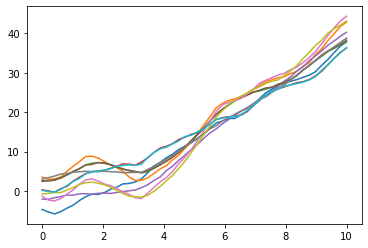

In [6]:
for i in range(n_gps):
    covs.append(eta[i]**2 * pm.gp.cov.ExpQuad(1, ls=ell[i]))
    
# construct the four "true" gps
gps = []
for i in range(n_gps):
    gps.append(np.random.multivariate_normal(np.zeros(s), covs[i](x[:,None]).eval(), size=1).flatten())
    
# construct y_set, the set of n time series, each one a mixture of the four gps
y_set = []
f_set = []
known_mixtures = [] # Question, are the mixture weights known? Answer: No
for i in range(n):
    mixture_weights = np.random.randint(0, 2, size=n_gps)
    
    # make sure its not all zeros...
    if sum(mixture_weights) == 0:
        ix = np.random.randint(3) # 0, 1 or 2
        mixture_weights[ix] = 1
        
    known_mixtures.append(mixture_weights)
        
    # define mixture 
    f = np.zeros(s)
    for i, w in enumerate(mixture_weights):
        f += gps[i] * w
   
    noise = sigma * np.random.randn(s)
    y = f + noise + piece[:,i]

    plt.plot(x, y)
    
    f_set.append(f)
    y_set.append(y)

In [7]:
## set up the pymc model
with pm.Model() as model:
    
    k = pm.Normal("k", mu=0, sigma=1, shape = n)
    m = pm.Normal("m", mu=0, sigma=1, shape = n)
    delta = pm.Normal("delta", mu=0, sigma=2, shape=(4,n))

    covs = []
    for i in range(1, n_gps + 1):
        eta = pm.HalfNormal(f'eta_{i}', sd=5)
        ell = pm.Gamma(f'ell_{i}', alpha=2, beta=1)
        cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
        covs.append(cov)
    
    # apply mixtures to covariances
    selected_covs = []
    mixed_covs = []
    for i in range(n):
        mixture_weights = known_mixtures[i]
        for w_ix in range(len(mixture_weights)):
            w = mixture_weights[w_ix]
            if w == 1.0:
                selected_covs.append(covs[w_ix])
        mixed_cov = sum(selected_covs) # because GP(cov1 + cov2) = GP(cov1) + GP(cov2)
        mixed_covs.append(mixed_cov) 
        selected_covs = [] # clear out cov list
     
    gps = []
    for i in range(n):
        piece = PiecewiseLinear(k = k[i],
                                  m = m[i],
                                  delta = delta[:,i],
                                  changepoints = np.linspace(0, s, 4))
        gp = pm.gp.Marginal(mean_func = piece,
                            cov_func=mixed_covs[i])
        gps.append(gp)
        
    
    noise = pm.HalfNormal('noise', sd=2)    
    for i in range(n):
        lik = gps[i].marginal_likelihood(f"lik_{i}", X=x[:, None], y=y_set[i], noise=noise)
   
    tr = pm.sample(draws=1000, tune=500, chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [noise, ell_4, eta_4, ell_3, eta_3, ell_2, eta_2, ell_1, eta_1, delta, m, k]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 1267 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
# predict length of each series
s_new = 60

x_new = np.linspace(0, 12, s_new)[:,None]

In [9]:
f_new = []

with model:
    for i in range(n):
        f_new.append(gps[i].conditional(f"f_new_{i}", Xnew=x_new, pred_noise=True))

In [10]:
with model:
    y_pred = pm.sample_posterior_predictive(tr,
                                           vars=[*f_new],
                                           samples=500)

/home/mach1ne/anaconda3/envs/phd/lib/python3.9/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


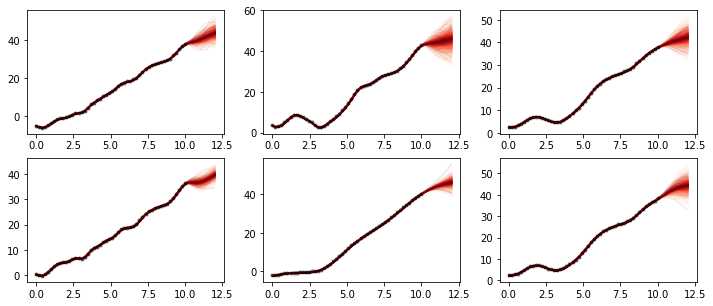

In [11]:
# plot the results
fig, ax = plt.subplots(2, 3, figsize=(12, 5))
ax = ax.ravel()

for i in range(6):
    plot_gp_dist(ax[i], y_pred[f"f_new_{i}"], x_new)

    # plot the data and the true latent function
    #plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
    ax[i].plot(x, y_set[i], "ok", ms=3, alpha=0.5, label="Observed data");